In [1]:
#load required modules
%pylab inline
import pandas as pd
import scipy.stats as st
import scipy.optimize as so
from scipy import special
import glob

#plotting modules
import seaborn as sns
sns.set(style='whitegrid', palette='deep')

Populating the interactive namespace from numpy and matplotlib


# Soil Water Retention and Soil Hydraulic Models
## Fitting of soil hydraulic models to data

This notebook looks at measured soil water retention properties and soil hydraulic models.

(cc) conrad.jackisch@tbt.tu-freiberg.de, Dec 09, 2021

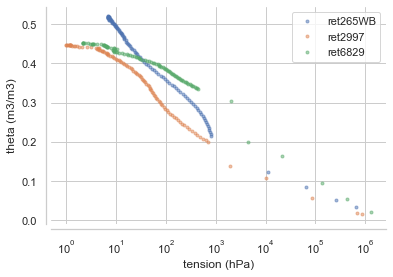

In [2]:
#get list of excel files holding the results of the retention measurements
#and read the data
fis = glob.glob('./ret*.xlsx')

def read_plot(fi, sn='Evaluation-Retention Θ(pF)'):
    ret = pd.read_excel(fi,sheet_name=sn)
    ret.columns = ['pF','theta','w']
    ret.theta *= 0.01
    ret['smpl'] = fi.split('.')[1][1:]
    plot(10**ret.pF,ret.theta,'.',alpha=0.5,label=fi.split('.')[1][1:])
    return ret

fis = glob.glob('./ret*.xlsx')
ret = read_plot(fis[0])
ret1 = read_plot(fis[1])
ret2 = read_plot(fis[2])

legend()
xlabel('tension (hPa)')
ylabel('theta (m3/m3)')
xscale('log')
#yscale('log')
sns.despine(offset=5)


In [3]:
## prepare equally spaced points along pF dimension for fitting of soil hydraulic function

# build array for pF:
sup=np.arange(0.,6.4,0.05)
# search for reference value in observations through lookup of minimal deviation
supportd=np.zeros((len(sup),3))
for i in np.arange(len(sup)):
    supportd[i,0]=np.argmin(np.abs(ret.pF-sup[i]))
    supportd[i,1]=np.argmin(np.abs(ret1.pF-sup[i]))
    supportd[i,2]=np.argmin(np.abs(ret2.pF-sup[i]))

#remove dublicates (soil 1) 
support=np.unique(supportd[:,0]).astype(int)
#construct pairs
supports=np.zeros([len(support),2])
supports[:,0]=10**ret.pF[support].values
supports[:,1]=ret.theta[support].values

#remove dublicates (soil 2)
support=np.unique(supportd[:,1]).astype(int)
#construct pairs
supports1=np.zeros([len(support),2])
supports1[:,0]=10**ret1.pF[support].values
supports1[:,1]=ret1.theta[support].values

#remove dublicates (soil 3)
support=np.unique(supportd[:,2]).astype(int)
#construct pairs
supports2=np.zeros([len(support),2])
supports2[:,0]=10**ret2.pF[support].values
supports2[:,1]=ret2.theta[support].values

#now we have three sets of pairs with equally spaced pF values and theta references

In [4]:
## soil hydraulic models
# we define the soil hydraulic models

# they all rely on matrix potential in mH2O -› hence we convert hPa to mH2O by division with 98.1 in the following steps
# a simple assumption of 1 hPa = 1 cmH2O = 0.01 mH2O could be equally sufficient
# likewise, the change in density with temperature could be considered, too.

def theta_thst(th_star,ths,thr):
    #Calculate soil moisture (theta) from relative saturation (theta*)
    theta=th_star*(ths-thr)+thr
    return theta

def thst_theta(theta,ths,thr):
    #Calculate relative saturation (theta*) from soil moisture (theta)
    th_star=(theta-thr)/(ths-thr) #
    return th_star

def theta_psi_vg(psi,ths,thr,alpha,n,m=None):
    #Calculate soil moisture (theta) from matrix head (psi) in m_H20
    #van Genuchten model
    if m is None:
        m=1.-1./n
    th_star = (1./(1.+(np.abs(psi)*alpha)**n))**m#
    theta=theta_thst(th_star,ths,thr)
    return theta

def theta_psi_bc(psi,ths,thr,psib,l):
    #Calculate soil moisture (theta) from matrix head (psi) in m_H20
    #Brooks and Corey model
    th_star = (psi/psib)**(-1*l)#
    theta=theta_thst(th_star,ths,thr)
    return theta

def theta_psi_kos(psi,ths,thr,hm,sig):
    #Calculate soil moisture (theta) from matrix head (psi) in m_H2O
    #Kosugi model
    theta=thr+0.5*(ths-thr)*special.erfc(np.log(psi/hm)/np.sqrt(2.*sig))
    return theta


/Users/cojack/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in power


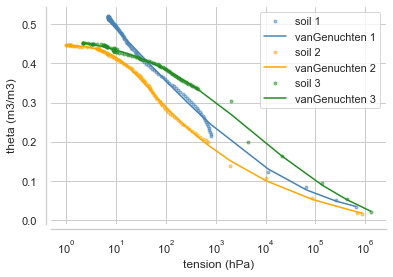

In [5]:
opt, covar = so.curve_fit(theta_psi_vg, supports[:,0]/98.1, supports[:,1], maxfev = 10000)
opt1, covar1 = so.curve_fit(theta_psi_vg, supports1[:,0]/98.1, supports1[:,1], maxfev = 10000)
opt2, covar2 = so.curve_fit(theta_psi_vg, supports2[:,0]/98.1, supports2[:,1], maxfev = 10000)

plot(10**ret.pF,ret.theta,'.',c='steelblue',alpha=0.5,label='soil 1')
plot(supports[:,0],theta_psi_vg(supports[:,0]/98.1,opt[0],opt[1],opt[2],opt[3],opt[4]),'-',c='steelblue',label='vanGenuchten 1')

plot(10**ret1.pF,ret1.theta,'.',c='orange',alpha=0.5,label='soil 2')
plot(supports1[:,0],theta_psi_vg(supports1[:,0]/98.1,opt1[0],opt1[1],opt1[2],opt1[3],opt1[4]),'-',c='orange',label='vanGenuchten 2')

plot(10**ret2.pF,ret2.theta,'.',c='forestgreen',alpha=0.5,label='soil 3')
plot(supports2[:,0],theta_psi_vg(supports2[:,0]/98.1,opt2[0],opt2[1],opt2[2],opt2[3],opt2[4]),'-',c='forestgreen',label='vanGenuchten 3')


legend()
xlabel('tension (hPa)')
ylabel('theta (m3/m3)')
xscale('log')
#yscale('log')
sns.despine(offset=5)

vG_fit=pd.concat([pd.DataFrame(np.append(np.array([opt[0],opt[1],opt[2],opt[3],opt[4]]),np.array(st.linregress(supports[:,1],theta_psi_vg(supports[:,0]/98.1,opt[0],opt[1],opt[2],opt[3],opt[4])))),index=['ths', 'thr', 'alpha', 'n', 'm', 'slope', 'intercept', 'r_value', 'p_value', 'std_err'],columns=[fis[0][4:-5]]),
                  pd.DataFrame(np.append(np.array([opt1[0],opt1[1],opt1[2],opt1[3],opt1[4]]),np.array(st.linregress(supports1[:,1],theta_psi_vg(supports1[:,0]/98.1,opt1[0],opt1[1],opt1[2],opt1[3],opt1[4])))),index=['ths', 'thr', 'alpha', 'n', 'm', 'slope', 'intercept', 'r_value', 'p_value', 'std_err'],columns=[fis[1][4:-5]]),
                  pd.DataFrame(np.append(np.array([opt2[0],opt2[1],opt2[2],opt2[3],opt2[4]]),np.array(st.linregress(supports2[:,1],theta_psi_vg(supports2[:,0]/98.1,opt2[0],opt2[1],opt2[2],opt2[3],opt2[4])))),index=['ths', 'thr', 'alpha', 'n', 'm', 'slope', 'intercept', 'r_value', 'p_value', 'std_err'],columns=[fis[2][4:-5]])],axis=1)


In [6]:
vG_fit

,t265WB,t2997,t6829
ths,1.273348e+00,4.466457e-01,4.796547e-01
thr,8.966395e-03,-5.273012e-02,-8.248808e-02
alpha,1.140281e-14,8.507195e+00,5.685420e-02
n,1.267400e-01,1.567258e+00,3.804491e-01
m,7.620290e+01,1.109384e-01,6.444699e-01
slope,9.942802e-01,9.985345e-01,9.944777e-01
intercept,1.993095e-03,4.720081e-04,2.073071e-03
r_value,9.971360e-01,9.992670e-01,9.972351e-01
p_value,3.084240e-53,1.790137e-82,2.956835e-59
std_err,1.111900e-02,5.066814e-03,1.037682e-02


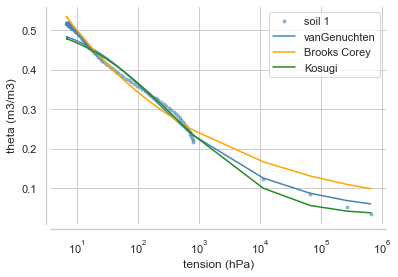

In [7]:
# guess ths and thr first:
def theta_psi_vgc(psi,alpha,n,m=None):
    ths = ret.theta.max()
    thr = ret.theta.min()
    return theta_psi_vg(psi,ths,thr,alpha,n,m)

def theta_psi_bcc(psi,psib,l):
    ths = ret.theta.max()
    thr = ret.theta.min()
    return theta_psi_bc(psi,ths,thr,psib,l)

def theta_psi_kosc(psi,hm,sig):
    ths = ret.theta.max()
    thr = ret.theta.min()
    return theta_psi_kos(psi,ths,thr,hm,sig)


opt, covar = so.curve_fit(theta_psi_vgc, supports[:,0]/98.1, supports[:,1], maxfev = 10000)
opt1, covar1 = so.curve_fit(theta_psi_bcc, supports[:,0]/98.1, supports[:,1], maxfev = 10000)
opt2, covar2 = so.curve_fit(theta_psi_kosc, supports[:,0]/98.1, supports[:,1], maxfev = 10000)

plot(10**ret.pF,ret.theta,'.',c='steelblue',alpha=0.5,label='soil 1')
plot(supports[:,0],theta_psi_vg(supports[:,0]/98.1,ret.theta.max(),ret.theta.min(),opt[0],opt[1],opt[2]),'-',c='steelblue',label='vanGenuchten')
plot(supports[:,0],theta_psi_bc(supports[:,0]/98.1,ret.theta.max(),ret.theta.min(),opt1[0],opt1[1]),'-',c='orange',label='Brooks Corey')
plot(supports[:,0],theta_psi_kos(supports[:,0]/98.1,ret.theta.max(),ret.theta.min(),opt2[0],opt2[1]),'-',c='forestgreen',label='Kosugi')


legend()
xlabel('tension (hPa)')
ylabel('theta (m3/m3)')
xscale('log')
#yscale('log')
sns.despine(offset=5)

fit=pd.concat([pd.DataFrame(np.append(np.array([ret.theta.max(),ret.theta.min(),opt[0],opt[1],opt[2]]),np.array(st.linregress(supports[:,1],theta_psi_vg(supports[:,0]/98.1,ret.theta.max(),ret.theta.min(),opt[0],opt[1],opt[2])))),index=['ths', 'thr', 'alpha', 'n', 'm', 'slope', 'intercept', 'r_value', 'p_value', 'std_err'],columns=['vG']),
               pd.DataFrame(np.append(np.array([opt1[0],opt1[1]]),np.array(st.linregress(supports[:,1],theta_psi_bc(supports[:,0]/98.1,ret.theta.max(),ret.theta.min(),opt1[0],opt1[1])))),index=['psib', 'l', 'slope', 'intercept', 'r_value', 'p_value', 'std_err'],columns=['BC']),
               pd.DataFrame(np.append(np.array([opt2[0],opt2[1]]),np.array(st.linregress(supports[:,1],theta_psi_kos(supports[:,0]/98.1,ret.theta.max(),ret.theta.min(),opt2[0],opt2[1])))),index=['hm', 'sig', 'slope', 'intercept', 'r_value', 'p_value', 'std_err'],columns=['Kos'])],axis=1)



In [8]:
fit

,vG,BC,Kos
ths,5.197000e-01,NaN,NaN
thr,3.350000e-02,NaN,NaN
alpha,1.767381e+00,NaN,NaN
n,7.596615e-01,NaN,NaN
m,4.118634e-01,NaN,NaN
slope,9.563707e-01,9.244742e-01,9.830248e-01
intercept,1.477133e-02,2.821561e-02,3.504590e-03
r_value,9.923593e-01,9.859989e-01,9.912830e-01
p_value,1.857613e-43,1.946698e-37,3.804511e-42
std_err,1.753193e-02,2.305206e-02,1.926358e-02


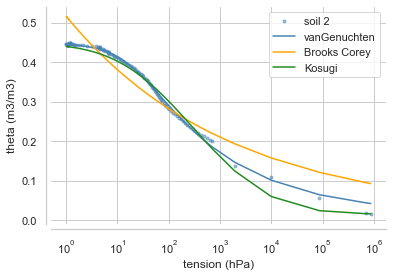

In [9]:
# guess ths and thr first:
def theta_psi_vgc(psi,alpha,n,m=None):
    ths = ret1.theta.max()
    thr = ret1.theta.min()
    return theta_psi_vg(psi,ths,thr,alpha,n,m)

def theta_psi_bcc(psi,psib,l):
    ths = ret1.theta.max()
    thr = ret1.theta.min()
    return theta_psi_bc(psi,ths,thr,psib,l)

def theta_psi_kosc(psi,hm,sig):
    ths = ret1.theta.max()
    thr = ret1.theta.min()
    return theta_psi_kos(psi,ths,thr,hm,sig)


opt, covar = so.curve_fit(theta_psi_vgc, supports1[:,0]/98.1, supports1[:,1], maxfev = 10000)
opt1, covar1 = so.curve_fit(theta_psi_bcc, supports1[:,0]/98.1, supports1[:,1], maxfev = 10000)
opt2, covar2 = so.curve_fit(theta_psi_kosc, supports1[:,0]/98.1, supports1[:,1], maxfev = 10000)

plot(10**ret1.pF,ret1.theta,'.',c='steelblue',alpha=0.5,label='soil 2')
plot(supports1[:,0],theta_psi_vg(supports1[:,0]/98.1,ret1.theta.max(),ret1.theta.min(),opt[0],opt[1],opt[2]),'-',c='steelblue',label='vanGenuchten')
plot(supports1[:,0],theta_psi_bc(supports1[:,0]/98.1,ret1.theta.max(),ret1.theta.min(),opt1[0],opt1[1]),'-',c='orange',label='Brooks Corey')
plot(supports1[:,0],theta_psi_kos(supports1[:,0]/98.1,ret1.theta.max(),ret1.theta.min(),opt2[0],opt2[1]),'-',c='forestgreen',label='Kosugi')


legend()
xlabel('tension (hPa)')
ylabel('theta (m3/m3)')
xscale('log')
#yscale('log')
sns.despine(offset=5)

fit=pd.concat([pd.DataFrame(np.append(np.array([ret1.theta.max(),ret1.theta.min(),opt[0],opt[1],opt[2]]),np.array(st.linregress(supports1[:,1],theta_psi_vg(supports1[:,0]/98.1,ret.theta.max(),ret.theta.min(),opt[0],opt[1],opt[2])))),index=['ths', 'thr', 'alpha', 'n', 'm', 'slope', 'intercept', 'r_value', 'p_value', 'std_err'],columns=['vG']),
               pd.DataFrame(np.append(np.array([opt1[0],opt1[1]]),np.array(st.linregress(supports1[:,1],theta_psi_bc(supports1[:,0]/98.1,ret.theta.max(),ret.theta.min(),opt1[0],opt1[1])))),index=['psib', 'l', 'slope', 'intercept', 'r_value', 'p_value', 'std_err'],columns=['BC']),
               pd.DataFrame(np.append(np.array([opt2[0],opt2[1]]),np.array(st.linregress(supports1[:,1],theta_psi_kos(supports1[:,0]/98.1,ret.theta.max(),ret.theta.min(),opt2[0],opt2[1])))),index=['hm', 'sig', 'slope', 'intercept', 'r_value', 'p_value', 'std_err'],columns=['Kos'])],axis=1)



In [10]:
fit

,vG,BC,Kos
ths,4.477000e-01,NaN,NaN
thr,1.570000e-02,NaN,NaN
alpha,5.015522e+00,NaN,NaN
n,1.176514e+00,NaN,NaN
m,2.203182e-01,NaN,NaN
slope,1.101241e+00,9.634725e-01,1.114879e+00
intercept,2.385667e-02,7.071089e-02,1.516788e-02
r_value,9.982050e-01,9.586387e-01,9.936964e-01
p_value,2.146469e-71,8.578879e-33,7.132086e-56
std_err,8.751323e-03,3.788970e-02,1.665937e-02


/Users/cojack/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in power
/Users/cojack/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in power


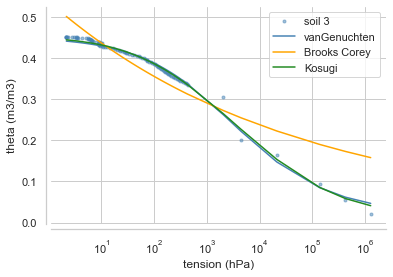

In [11]:
# guess ths and thr first:
def theta_psi_vgc(psi,alpha,n,m=None):
    ths = ret2.theta.max()
    thr = ret2.theta.min()
    return theta_psi_vg(psi,ths,thr,alpha,n,m)

def theta_psi_bcc(psi,psib,l):
    ths = ret2.theta.max()
    thr = ret2.theta.min()
    return theta_psi_bc(psi,ths,thr,psib,l)

def theta_psi_kosc(psi,hm,sig):
    ths = ret2.theta.max()
    thr = ret2.theta.min()
    return theta_psi_kos(psi,ths,thr,hm,sig)


opt, covar = so.curve_fit(theta_psi_vgc, supports2[:,0]/98.1, supports2[:,1], maxfev = 10000)
opt1, covar1 = so.curve_fit(theta_psi_bcc, supports2[:,0]/98.1, supports2[:,1], maxfev = 100000)
opt2, covar2 = so.curve_fit(theta_psi_kosc, supports2[:,0]/98.1, supports2[:,1], maxfev = 10000)

plot(10**ret2.pF,ret2.theta,'.',c='steelblue',alpha=0.5,label='soil 3')
plot(supports2[:,0],theta_psi_vg(supports2[:,0]/98.1,ret2.theta.max(),ret2.theta.min(),opt[0],opt[1],opt[2]),'-',c='steelblue',label='vanGenuchten')
plot(supports2[:,0],theta_psi_bc(supports2[:,0]/98.1,ret2.theta.max(),ret2.theta.min(),opt1[0],opt1[1]),'-',c='orange',label='Brooks Corey')
plot(supports2[:,0],theta_psi_kos(supports2[:,0]/98.1,ret2.theta.max(),ret2.theta.min(),opt2[0],opt2[1]),'-',c='forestgreen',label='Kosugi')


legend()
xlabel('tension (hPa)')
ylabel('theta (m3/m3)')
xscale('log')
#yscale('log')
sns.despine(offset=5)

fit=pd.concat([pd.DataFrame(np.append(np.array([ret2.theta.max(),ret2.theta.min(),opt[0],opt[1],opt[2]]),np.array(st.linregress(supports2[:,1],theta_psi_vg(supports2[:,0]/98.1,ret.theta.max(),ret.theta.min(),opt[0],opt[1],opt[2])))),index=['ths', 'thr', 'alpha', 'n', 'm', 'slope', 'intercept', 'r_value', 'p_value', 'std_err'],columns=['vG']),
               pd.DataFrame(np.append(np.array([opt1[0],opt1[1]]),np.array(st.linregress(supports2[:,1],theta_psi_bc(supports2[:,0]/98.1,ret.theta.max(),ret.theta.min(),opt1[0],opt1[1])))),index=['psib', 'l', 'slope', 'intercept', 'r_value', 'p_value', 'std_err'],columns=['BC']),
               pd.DataFrame(np.append(np.array([opt2[0],opt2[1]]),np.array(st.linregress(supports2[:,1],theta_psi_kos(supports2[:,0]/98.1,ret.theta.max(),ret.theta.min(),opt2[0],opt2[1])))),index=['hm', 'sig', 'slope', 'intercept', 'r_value', 'p_value', 'std_err'],columns=['Kos'])],axis=1)


In [12]:
fit

,vG,BC,Kos
ths,4.514000e-01,NaN,NaN
thr,2.060000e-02,NaN,NaN
alpha,4.595247e-02,NaN,NaN
n,5.118037e-01,NaN,NaN
m,8.462529e-01,NaN,NaN
slope,1.091425e+00,8.719294e-01,1.101692e+00
intercept,2.288427e-02,1.086187e-01,1.959157e-02
r_value,9.950373e-01,9.208772e-01,9.961651e-01
p_value,8.661085e-53,1.645492e-22,1.225984e-55
std_err,1.528278e-02,5.168864e-02,1.354943e-02


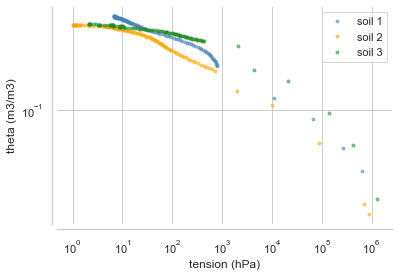

In [13]:
#play with log scales...
plot(10**ret.pF,ret.theta,'.',c='steelblue',alpha=0.5,label='soil 1')
plot(10**ret1.pF,ret1.theta,'.',c='orange',alpha=0.5,label='soil 2')
plot(10**ret2.pF,ret2.theta,'.',c='forestgreen',alpha=0.5,label='soil 3')

legend()
xlabel('tension (hPa)')
ylabel('theta (m3/m3)')
xscale('log')
yscale('log')
sns.despine(offset=5)



Apply your knowledge about the soil hydraulic models and include some retention model results in an appropriate log/log plot.